In [1]:
import numpy as np
import pandas as pd
# Because we run it on X-less cluster
import matplotlib as mpl
mpl.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline
from os import path as Path
import matplotlib.gridspec as GS

## ⚠️ Warning
This notebook was run on a cluster with 64 cores. It may take hours to complete on a desktop/laptop

## Head orientation from Body orientation prediction

In this part of the tutorial we will explain how to use the results we obtained in the Training tutorial to choose the best classifier for every configuration. For that we need to load all networks with the same configuration and compare them. Here we use the error angle as comparison. For that we calculate the median error angle of every network and then use the one with the smalles median error angle.
Afterwards we store the same information as before in another file, but this time only of the results of the best network

first we need our range again

In [2]:
ws = range(1,2,2)#(1,53,2)
neurons = [16]#[1,2,4,8,16,32,64,128]
Shift = [None]#list(range(-2,0,2))+[None]#list(range(-25,25,2))+[None]
headbody = [False]

N=[1]
override = False

Then we iterate through all networks and put those, that have the same configuration in a list and calculate their median error angle. Then we choose that network with the smallest error, which will be the best network with this configuration. Then we save the results of all best networks (one for each configuration) in the same file. If we already have the medians computed (to save storage space, like explained in the end of chapter 6b), we can also use the median file also for further analyses we are only interested in shift 0 for the moment.

In [3]:
for window_size1 in ws:
    for units1 in neurons:
        for shift1 in [None]:
            for rev1 in headbody:
                pred_norm = []
                error_angle = []
                window_size = []
                units = []
                test_target = []
                test_target_error = []
                shift = []
                observations = []
                best_index= -1
                best_val = 1
                for N1 in N:
                    path = 'chapter_4_results/Run'+str(N1)
                    file = path + '/feed_forward_results_N_'+str(N1)+'_.h5'
                    filemedian = path + '/feed_forward_results_N_'+str(N1)+'_median_None.h5'
                    medianexists = Path.exists(filemedian)
                    key = '/forward_{}/temporal_{}/window_size_{}/units_{}'.format(rev1, shift1,window_size1,units1)
                    
                    if medianexists:
                        pred_angle = pd.read_hdf(filemedian,key = key).astype(float)
                    else:
                        pred_angle = pd.read_hdf(file,key = key).astype(float)

                    pred_norm.append(pred_angle['pred_norm'])
                    error_angle.append(pred_angle['error_angle'])
                    test_target.append(pred_angle['test_target'])
                    test_target_error.append(pred_angle['test_target_error'])
                    observations.append(pred_angle['test_observations'])
                    
                    if medianexists:
                        error = pred_angle['error_angle']
                    else:
                        error = pred_angle['error_angle'].median()

                    if error < best_val:
                        best_index = N1-1
                        best_val = error

    
                pred_norm = pred_norm[best_index]
                error_angle = error_angle[best_index]
                test_target = test_target[best_index]
                test_target_error = test_target_error[best_index]
                observations = observations[best_index]

                pred_angle['pred_norm'] = pred_norm
                pred_angle['error_angle'] = error_angle
                pred_angle['test_target'] = test_target
                pred_angle['test_target_error'] = test_target_error

                path = 'chapter_4_results/Best/'
                filename = path + 'feed_forward_results_max_.h5'
                if Path.exists(filename):
                    if override:
                        with pd.HDFStore(filename) as hdf:
                            key = '/forward_{}/temporal_{}/window_size_{}/units_{}'.format(rev1, shift1,window_size1,units1)
                            hdf.put(key, pred_angle,format='table')
                else:
                    with pd.HDFStore(filename) as hdf:
                        key = '/forward_{}/temporal_{}/window_size_{}/units_{}'.format(rev1, shift1,window_size1,units1)
                        hdf.put(key, pred_angle,format='table')

print("Done")

Done


In [4]:
N = 1
headbody = False
shift = None
window_size = 23
units = 16

path = 'chapter_4_results/Best/'
filename = path + 'feed_forward_results_median_None.h5'

key = '/forward_{}/temporal_{}/window_size_{}/units_{}'.format(headbody, shift,window_size,units)
results_test = pd.read_hdf(filename, key=key)

results_test.head()

N  error_angle  shift  units    ws
0  32.0     0.202202    NaN   16.0  23.0

Now we can use the results to find the best window size and number of hidden neurons. For this we first need to change the form of the results dataframe, so that we can access all results for the different neurons and window sizes easily without having to pass the key every time.

In [5]:
def load_result(shift = None, headbody = False):
    ws = range(1,53,2)
    units_s = [1,2,4,8,16,32,64,128]
    result = None
    for ws1 in range(1,53,2):
        for un in units_s:
            key = '/forward_{}/temporal_{}/window_size_{}/units_{}'.format(headbody, shift,ws1,un)
            df = pd.read_hdf(filename, key=key).astype(float)
            if result is None:
                result = pd.read_hdf(filename, key=key).astype(float)
            else:
                result = pd.concat([result, pd.read_hdf(filename, key=key).astype(float)])
    return result

In [6]:
# -- reverse
result_rev = load_result(shift = None, headbody = False)
result_rev = result_rev.set_index(['ws','units'])
df_rev = result_rev

result= load_result(shift = None, headbody = True)
result = result.set_index(['ws','units'])
df = result

In [7]:
df_rev.head()

N  error_angle  shift
ws  units                          
1.0 1.0    22.0     0.220729    NaN
    2.0     6.0     0.224772    NaN
    4.0    34.0     0.234006    NaN
    8.0    38.0     0.258815    NaN
    16.0    3.0     0.265889    NaN

We reformat the dataframe such as the neurons and window_size are in columns and rows respectively. That
will become handy to show a colour plot

We also get the best combination of neurons and window_size, to show performance not only in colour but also with line. 

In [8]:
metric = 'error_angle'
score_NN_rev = df_rev[metric].unstack()
# Look for the best prediction, i.e. the minimum metric
best_idx_rev = df_rev[metric].idxmin()

score_NN = df[metric].unstack()
# Look for the best prediction, i.e. the minimum metric
best_idx = df[metric].idxmin()

We restrict the colourspace to between minimum and 99th percentile, to remove outliers. 

In [9]:
vmin = np.min([score_NN_rev.values,score_NN.values])
vmax = np.max([score_NN_rev.values,score_NN.values])

The figure will be 2x1 for body->head (direct) predictions. The number of neurons tested is lower than the number of window sizes. Therefore we will give more space for the window sizes. We thus use a gridspec of 3,4

Text(0, 0.5, 'RMSE')

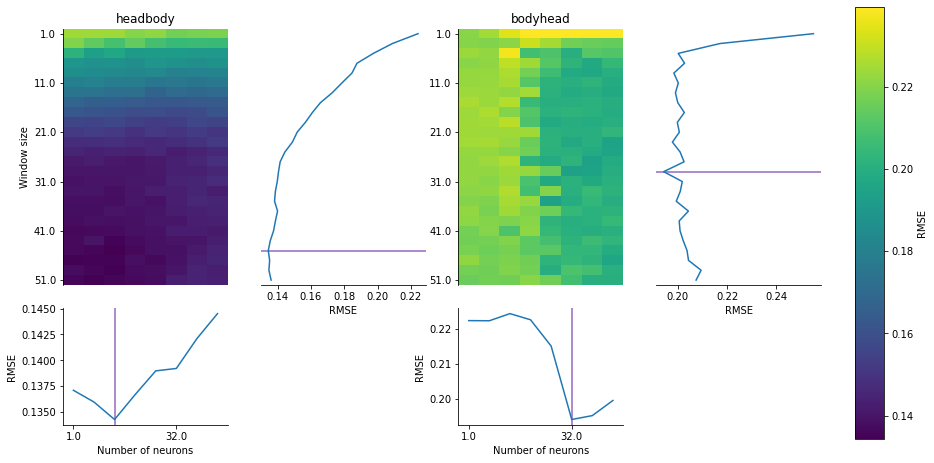

In [10]:
fig = plt.figure(figsize=(40,15))
axarr = dict()
gs = GS.GridSpec(6, 10)
axarr['colour_headbody'] = fig.add_subplot(gs[:2, 0]) # The two first
axarr['colour_bodyhead'] = fig.add_subplot(gs[:2, 2]) # The two first
axarr['cst_ws_headbody'] = fig.add_subplot(gs[2, 0], sharex=axarr['colour_headbody']) 
axarr['cst_ws_bodyhead'] = fig.add_subplot(gs[2, 2], sharex=axarr['colour_bodyhead']) 
axarr['cst_n_headbody'] = fig.add_subplot(gs[:2, 1], sharey=axarr['colour_headbody']) 
axarr['cst_n_bodyhead'] = fig.add_subplot(gs[:2, 3], sharey=axarr['colour_bodyhead']) 
# Format result in dictionary to ease ploting
scores = dict()
scores['bodyhead'] = score_NN_rev
scores['headbody'] = score_NN

bests_idx = dict()
bests_idx['bodyhead'] = best_idx_rev
bests_idx['headbody'] = best_idx


# First plot the colours
for direction in ['bodyhead','headbody']:
    ax = axarr['colour_{}'.format(direction)]
    toplot = scores[direction]
    
    im = ax.imshow(toplot, vmin=vmin, vmax=vmax*0.9, aspect="auto")
    ticks = np.arange(0,toplot.shape[1],5)
    ax.set_xticks(ticks)
    ax.set_xticklabels(toplot.columns[ticks])
    ticks = np.arange(0,toplot.shape[0],5)
    ax.set_yticks(ticks)
    ax.set_yticklabels(toplot.index[ticks])
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['bottom'].set_color(None)
    ax.tick_params(right= False,top= False, bottom=False, labelbottom=False)
    ax.set_ylabel('Window size')
    ax.set_title(direction)
    
# Second we plot the best along the window_size
for direction in ['bodyhead','headbody']:
    ax = axarr['cst_ws_{}'.format(direction)]
    toplot = scores[direction]
    besti = bests_idx[direction]

    ax.plot(np.arange(toplot.loc[besti[0]].shape[0]),toplot.loc[besti[0]].values)
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.set_ylabel('RMSE')
    ax.set_xlabel('Number of neurons')
    # plot line for best loc
    ax.axvline(np.where(toplot.columns==besti[1])[0], color='C4', zorder=0)
    # Plot error line
    #ax.plot(np.arange(ref.loc[besti[0]].shape[0]),ref.loc[besti[0]].values)
    
# Third we plot the best along the neurons    
for direction in ['bodyhead','headbody']:
    ax = axarr['cst_n_{}'.format(direction)]
    toplot = scores[direction]
    besti = bests_idx[direction]
    
    ax.plot(toplot.loc[:,besti[1]].values, np.arange(toplot.loc[:,besti[1]].shape[0]))
    ax.spines['top'].set_color(None)
    ax.spines['right'].set_color(None)
    ax.spines['left'].set_color(None)
    ax.tick_params(right= False,top= False, left=False, labelleft=False)
    ax.set_xlabel('RMSE')
    # plot line for best loc
    ax.axhline(np.where(toplot.index==besti[0])[0], color='C4', zorder=0)
    # Plot error line
    #ax.plot(ref.loc[:,besti[1]].values, np.arange(ref.loc[:,besti[1]].shape[0]))    

#
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.4, 0.50, 0.01, 0.4])
fig.colorbar(im, cax=cbar_ax)
cbar_ax.set_ylabel('RMSE')

We can do almost the same if we want to find the best shift, just that we do not find the best model on the different runs but over the best run, window size and hidden layer size. Here an example only for Run0 (because of storage limitation). 

In [12]:
for rev1 in [True,False]:
    for shift1 in [None]:#list(range(-25,25,2))+[None]:
        dfs = []
        print("calculating shift "+str(shift1)+" rev "+str(rev1))
        best_index= -1
        best_val = 1
        index =0
        for units1 in [1,2,4,8,16,32,64,128]:
            for window_size1 in range(1,53,2):
                    for N in [0]: #range(40)
                        path = 'chapter_4_results/Run'+str(N)
                        file = path + '/feed_forward_results_N_'+str(N)+'_.h5'
                        filemedian = path + '/feed_forward_results_N_'+str(N)+'_medians_None.h5'
                        medianexists = Path.exists(filemedian)
                        key = '/forward_{}/temporal_{}/window_size_{}/units_{}'.format(rev1, shift1,window_size1,units1)
                        if not medianexists:
                            pred_angle = pd.read_hdf(file,key = key).astype(float)
                        else:
                            pred_angle = pd.read_hdf(filemedian,key = key).astype(float)
                    
                        dfs.append(pred_angle)

                        if not medianexists:
                            # Calculate median errors
                            error = pred_angle['error_angle'].median()
                        else:
                            error = pred_angle['error_angle'].values[0]
                            
                        
                        if error < best_val:
                            best_index = index
                            best_val = error
                            best_units = units1
                            best_ws = window_size1
                            best_N = N
                        
                        index=index+1
                
                
        pred_angle = dfs[best_index]
        pred_angle['N'] = best_N
        pred_angle['units'] = best_units
        pred_angle['ws'] = best_ws
            
            
            
        path = 'chapter_4_results/Best/'
        filename = path + 'feed_forward_results_per_shift_40.h5'
        if Path.exists(filename):
            if override:
                with pd.HDFStore(filename) as hdf:
                    key = '/forward_{}/temporal_{}'.format(rev1, shift1)
                    hdf.put(key, pred_angle,format='table')
        else:
            with pd.HDFStore(filename) as hdf:
                key = '/forward_{}/temporal_{}'.format(rev1, shift1)
                hdf.put(key, pred_angle,format='table')

calculating shift None rev True
calculating shift None rev False
